# Explorações no tempo

**Objetivo do projeto**: Utilizar a abordagem de "hierarchical forecasting" para projetar múltiplas séries temporais

## 0. Setup

In [1]:
%load_ext autotime

time: 157 µs (started: 2023-12-30 12:12:00 -03:00)


In [2]:
#---- Manipulação de dados:

import pandas as pd
import numpy as np

#---- Visualização de dados:

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt

time: 2.06 s (started: 2023-12-30 12:12:00 -03:00)


## 1. Dados: vendas de roupas no varejo

In [3]:
dados = pd.read_csv('https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-hierarchical-forecasting/main/retail-usa-clothing.csv')

dados.head()

date    state           item  quantity       region country
0  1997-11-25  NewYork  mens_clothing         8  Mid-Alantic     USA
1  1997-11-26  NewYork  mens_clothing         9  Mid-Alantic     USA
2  1997-11-27  NewYork  mens_clothing        11  Mid-Alantic     USA
3  1997-11-28  NewYork  mens_clothing        11  Mid-Alantic     USA
4  1997-11-29  NewYork  mens_clothing        10  Mid-Alantic     USA

time: 1.85 s (started: 2023-12-30 12:12:02 -03:00)


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388024 entries, 0 to 388023
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      388024 non-null  object
 1   state     388024 non-null  object
 2   item      388024 non-null  object
 3   quantity  388024 non-null  int64 
 4   region    388024 non-null  object
 5   country   388024 non-null  object
dtypes: int64(1), object(5)
memory usage: 17.8+ MB
time: 68.2 ms (started: 2023-12-30 12:12:03 -03:00)


## 2. Correção nos dados

In [5]:
#---- Criando uma cópia dos dados

df = dados\
    .copy()

time: 12.3 ms (started: 2023-12-30 12:12:04 -03:00)


In [6]:
#---- Transformando para datetime a variável "date"

df['date'] = pd.to_datetime(df['date'])

df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 388024 entries, 0 to 388023
Series name: date
Non-Null Count   Dtype         
--------------   -----         
388024 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.0 MB
time: 79.6 ms (started: 2023-12-30 12:12:04 -03:00)


## 2. Análises 

### 2.1. Vendas por dia

- Pelo fato da série ter um período relativamente longo, com essa visão geral não conseguimos visualizar sazonalidade
- Mas existe uma tendência no aumento das vendas no varejo, perceptível a partir dos anos 2000

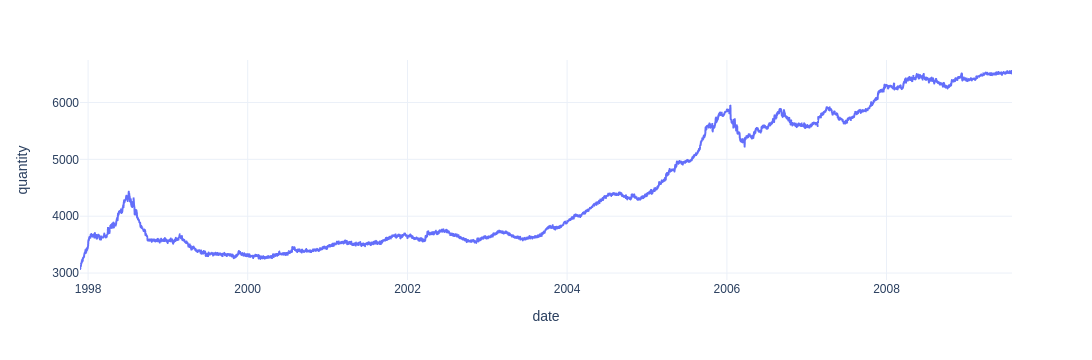

time: 830 ms (started: 2023-12-30 12:12:04 -03:00)


In [7]:
#---- Dataset:

df_vendas_dia = df\
    .groupby('date', as_index = False)['quantity']\
    .sum()

#---- Gráfico:

fig = px.line(df_vendas_dia, x = 'date', y = 'quantity', template = 'plotly_white')
fig.show()

### 2.2. Vendas por estados

**Estados com crescimento nas vendas nos últimos meses:**

- Alabama
- Hawaii
- Illinois
- Indiana
- Kentucky
- Mississipi
- New York

**Estados com vendas estáveis nos últimos meses:**

- California
- Maine
- New Jersey
- Ohio
- Oregon
- Phensylvania
- RhodeIsland
- Thenessee
- Vermont

**Estados com decrescimento nas vendas nos últimos meses:**
 
- Alaska

In [8]:
#---- Dataset de vendas por estado:

df_vendas_dia = df\
    .groupby(['date', 'state'], as_index = False)['quantity']\
    .sum()

time: 59.9 ms (started: 2023-12-30 12:12:04 -03:00)


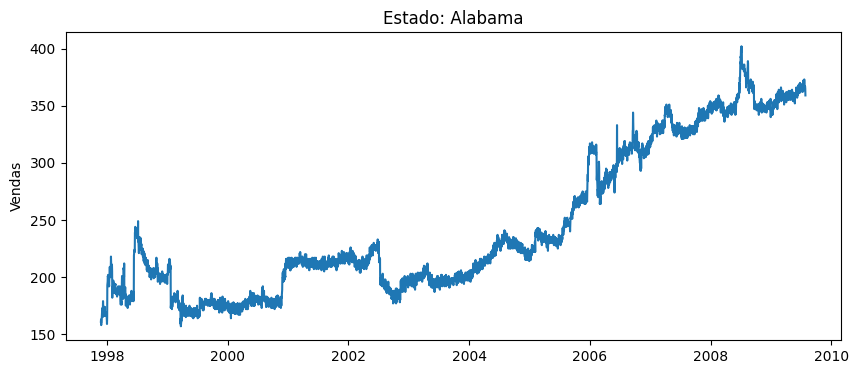

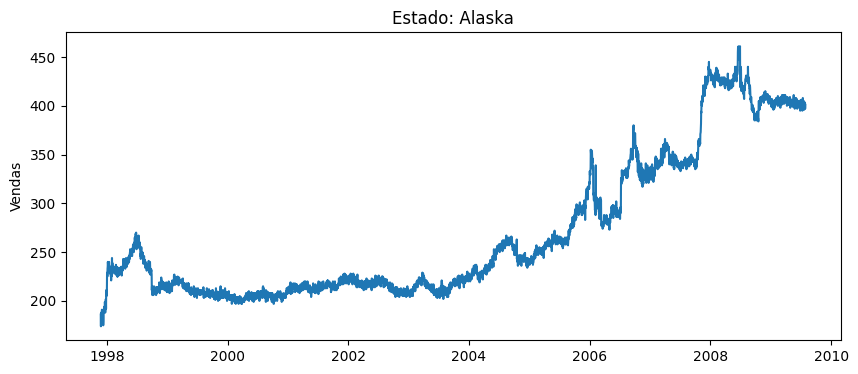

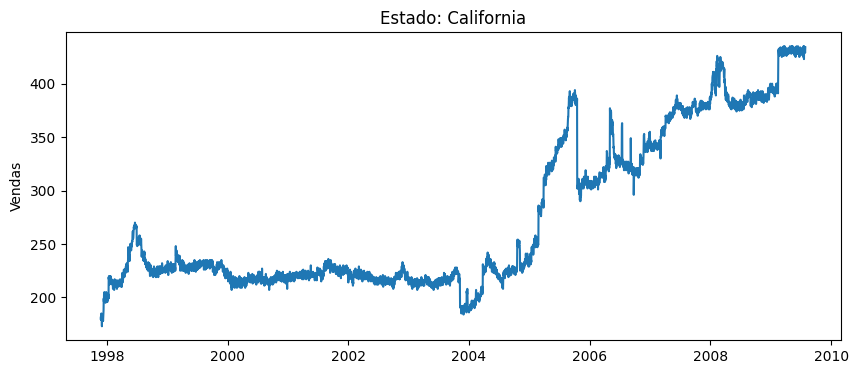

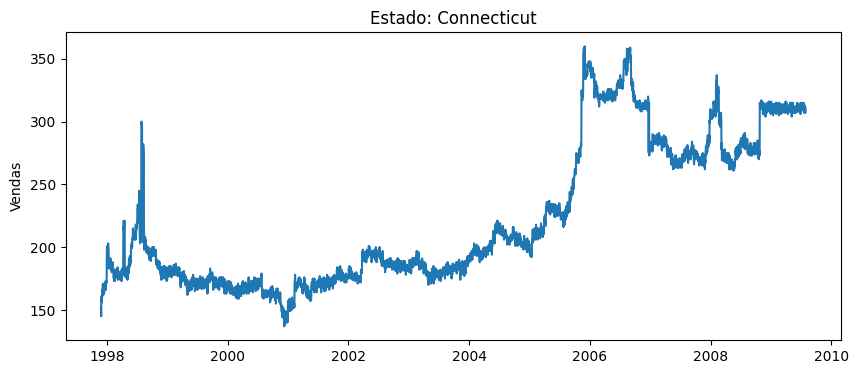

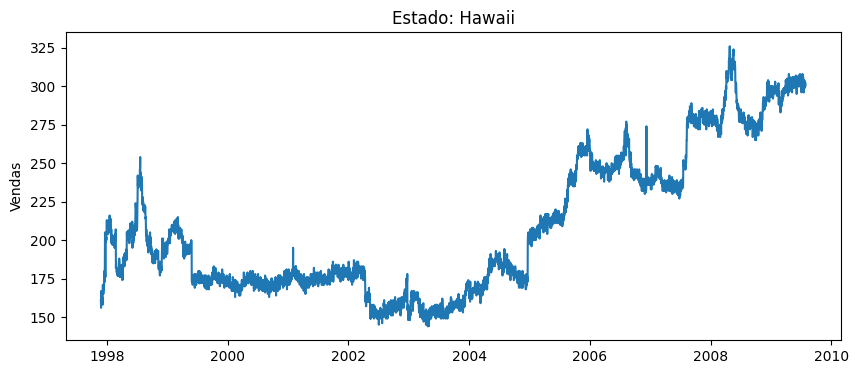

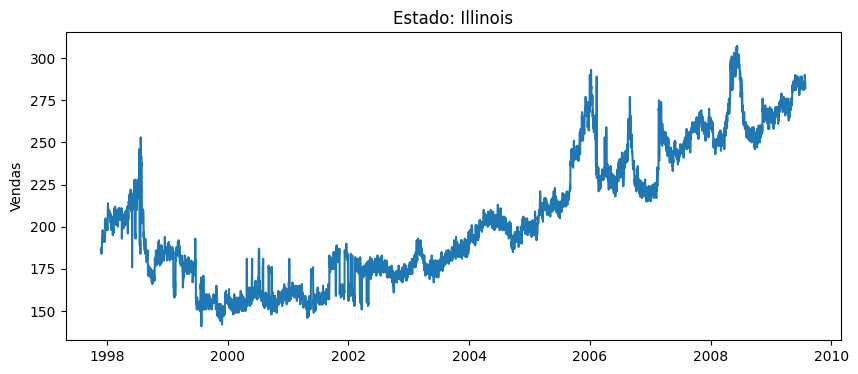

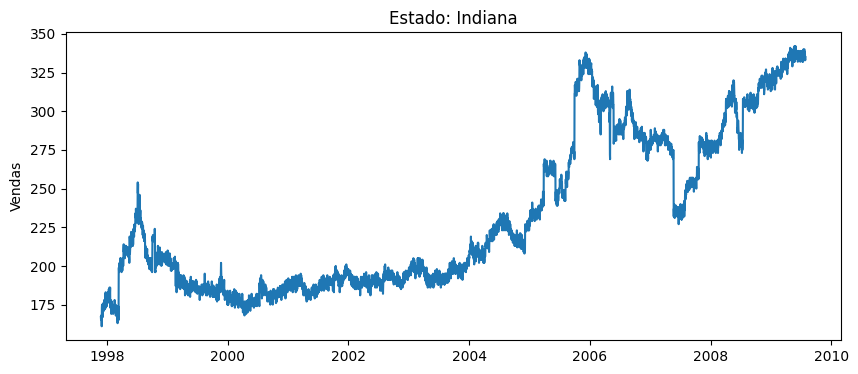

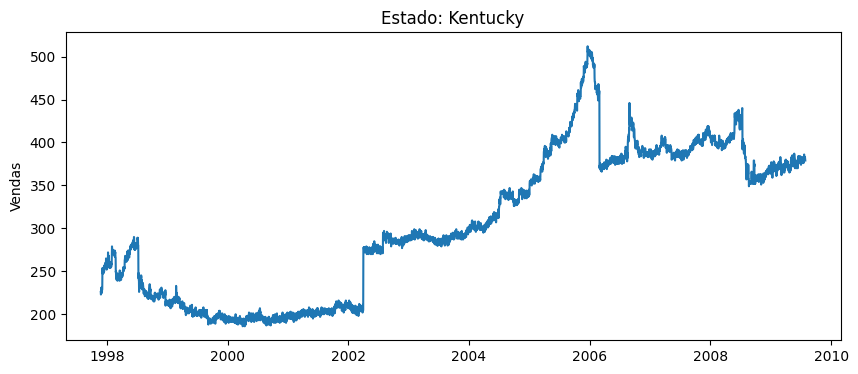

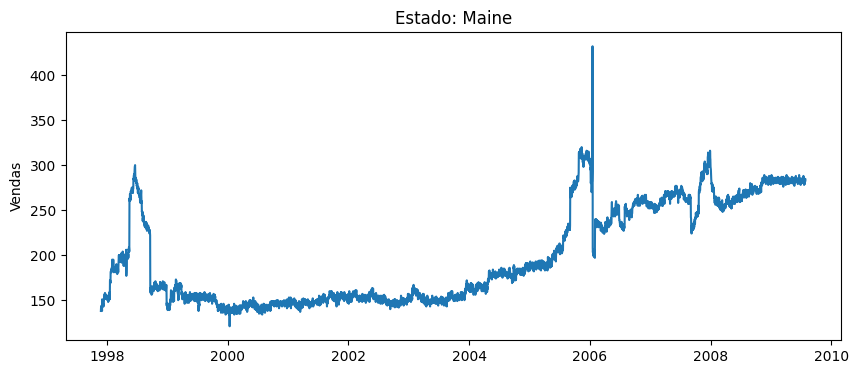

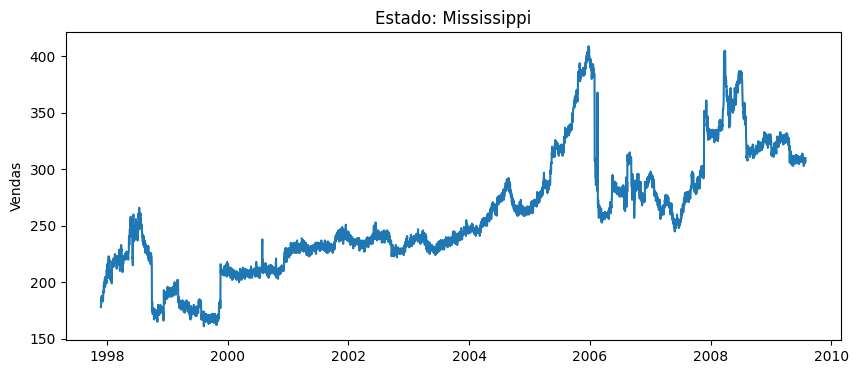

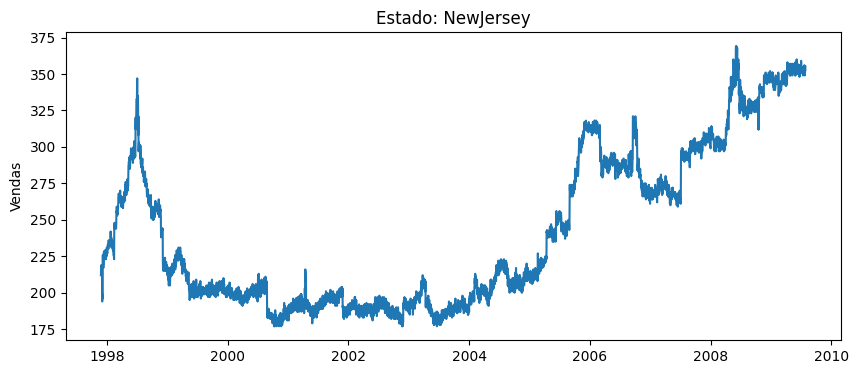

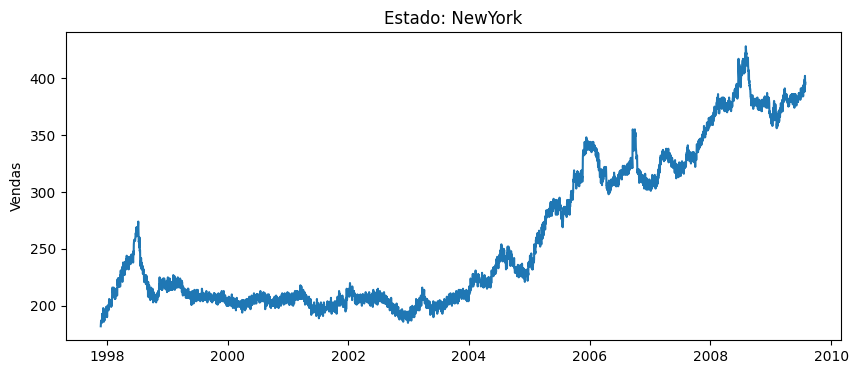

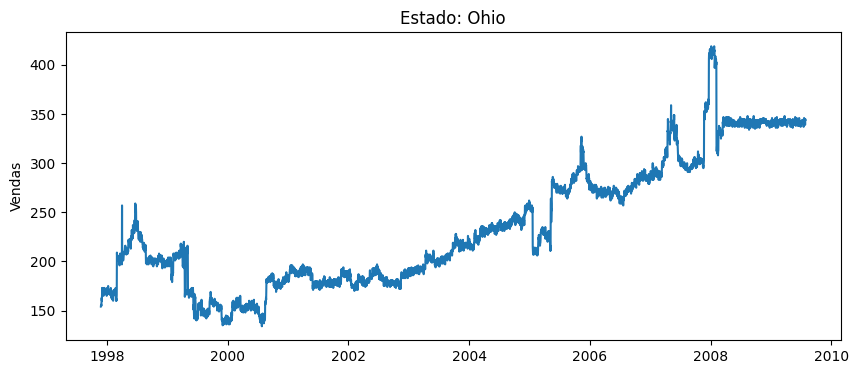

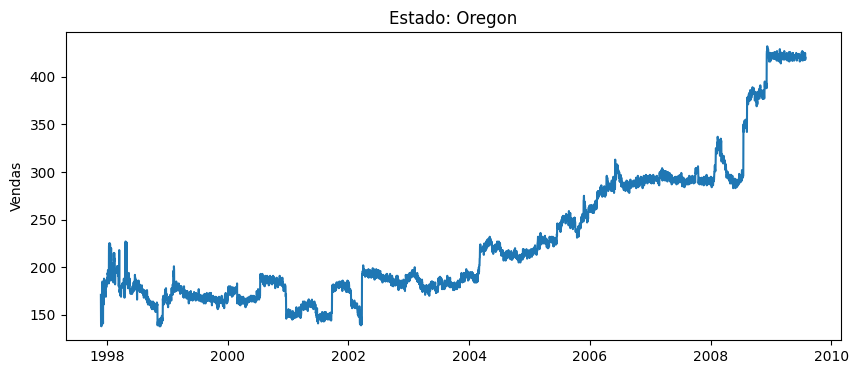

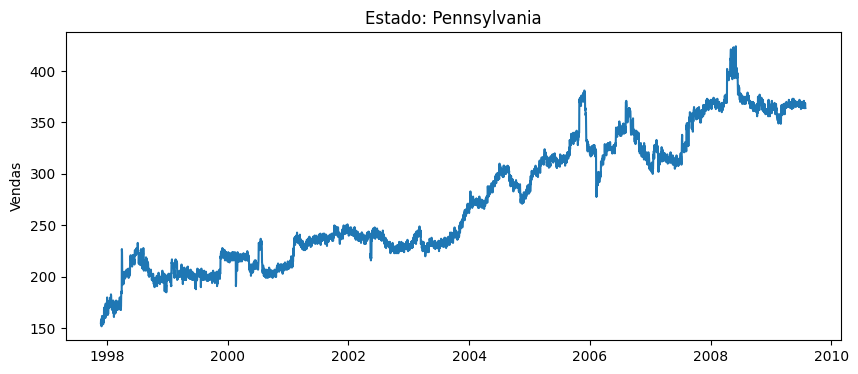

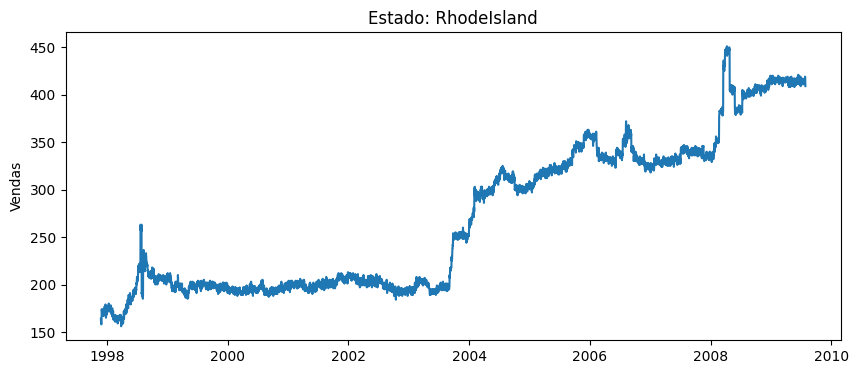

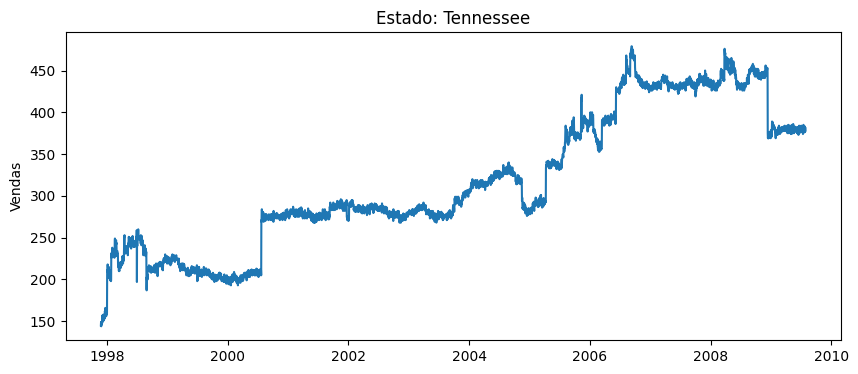

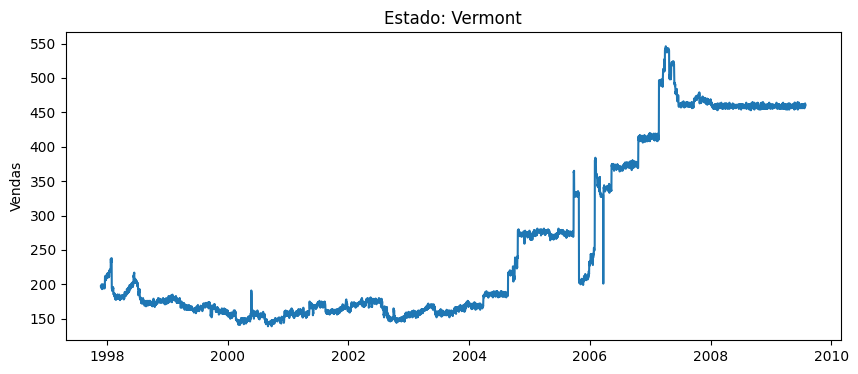

time: 5.33 s (started: 2023-12-30 12:12:05 -03:00)


In [9]:
#---- Loop para a construção dos gráficos:

for state in df_vendas_dia.state.unique():

    df_temp = df_vendas_dia\
        .query(f'state == "{state}"')
    
    plt.figure(figsize = (10, 4))
    
    _ = sns.lineplot(data = df_temp, x = 'date', y = 'quantity')
    _ = _.set_title(f'Estado: {state}')
    _ = plt.ylabel('Vendas')
    _ = plt.xlabel('')

### 2.3. Vendas por itens

- A série temporal de vendas de roupas de crianças acompanha a série de vendas geral (é o 2º item com mais vendas, como visto no notebook anterior)
- Sapatos de crianças estão com baixa nas vendas desde 1998, início da série
- Vendas de roupas masculinas são extremamente sazonais
- Vendas de sapatos masculinos cresceram de 1998 a 2005 e, desde 2005, mantém estabilidade
- Vendas de roupas femininas só crescem, mas nos últimos meses se tornaram estáveis
- Vendas de sapatos femininos tiveram um aumento considerável entre os anos de 2003 e 2005, mas desde 2008 se mantém constante

In [10]:
#---- Dataset de vendas por estado:

df_vendas_dia = df\
    .groupby(['date', 'item'], as_index = False)['quantity']\
    .sum()

time: 52.4 ms (started: 2023-12-30 12:12:10 -03:00)


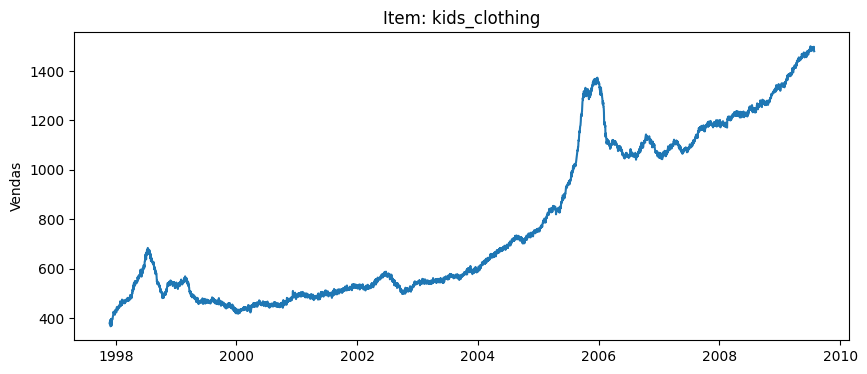

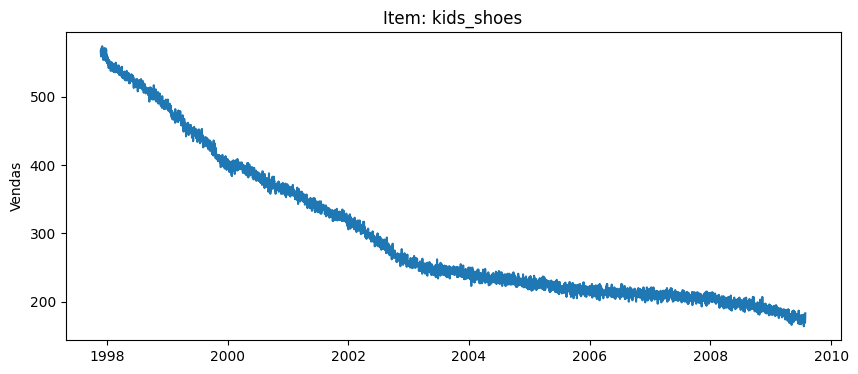

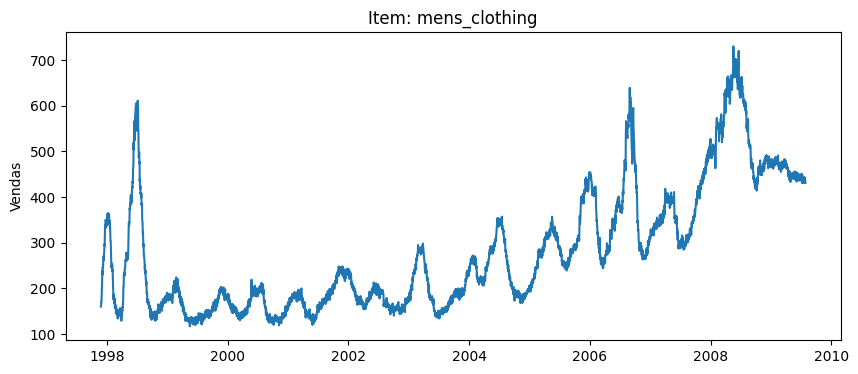

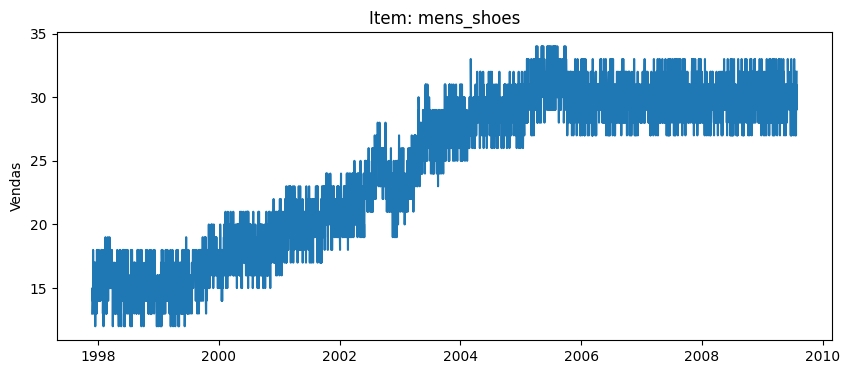

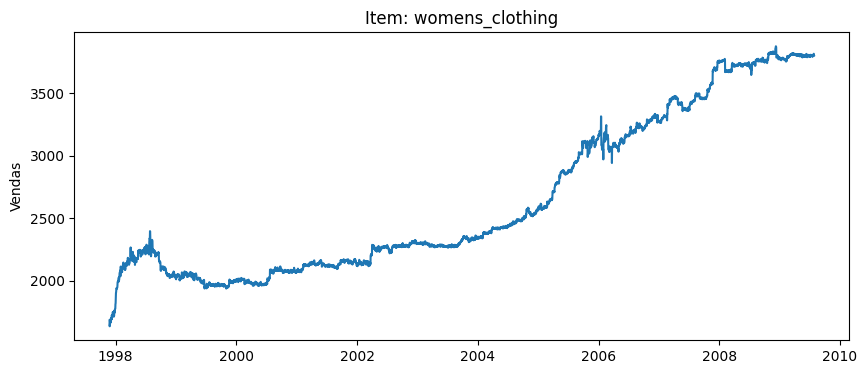

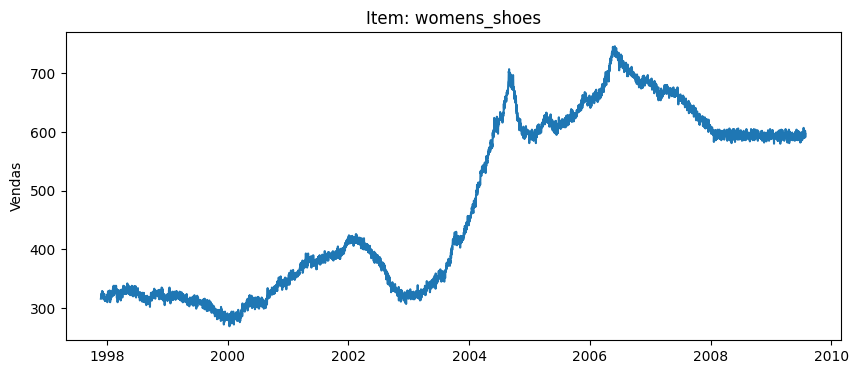

time: 1.77 s (started: 2023-12-30 12:12:10 -03:00)


In [11]:
#---- Loop para a construção dos gráficos:

for item in df_vendas_dia.item.unique():

    df_temp = df_vendas_dia\
        .query(f'item == "{item}"')
    
    plt.figure(figsize = (10, 4))
    
    _ = sns.lineplot(data = df_temp, x = 'date', y = 'quantity')
    _ = _.set_title(f'Item: {item}')
    _ = plt.ylabel('Vendas')
    _ = plt.xlabel('')

### 2.4. Combinação com maior quantidade de vendas

**Notem que iremos fazer projeções para cada combinação distinta das variáveis**: state, item e region. Para isso vamos verificar qual combinação dessas 3 variáveis tem a maior quantidade de vendas.

In [12]:
#---- Criando a variável de combinação:

df['combination'] = df['state'] + '/' + df['item'] + '/' + df['region']

time: 122 ms (started: 2023-12-30 12:12:12 -03:00)


- Roupas femininas nas top5 combinações mais vendidas
- SouthCentral é a região com maior quantidade de vendas entre as combinações (top1 e top2)

In [13]:
#---- Qual a combinação com maior quantidade de vendas:

df_combinacao_vendas = df\
    .groupby('combination', as_index = False)['quantity']\
    .sum()\
    .sort_values(by = 'quantity', ascending = False)

df_combinacao_vendas.head()

combination  quantity
85    Tennessee/womens_clothing/SouthCentral    911057
39     Kentucky/womens_clothing/SouthCentral    850494
89        Vermont/womens_clothing/NewEngland    785044
14        California/womens_clothing/Pacific    752137
75  Pennsylvania/womens_clothing/Mid-Alantic    739238

time: 44.9 ms (started: 2023-12-30 12:12:12 -03:00)


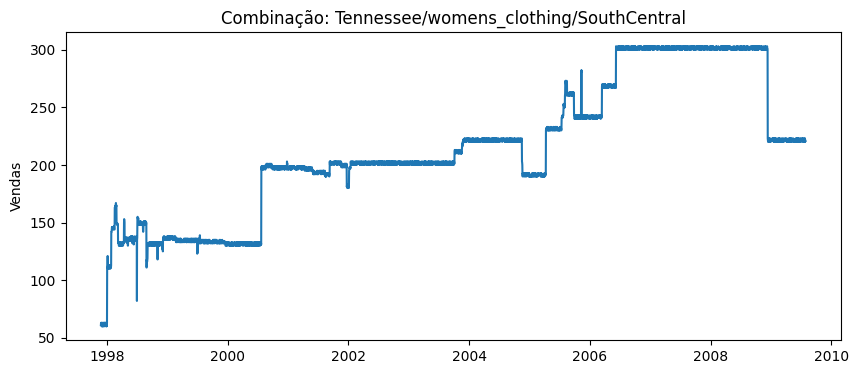

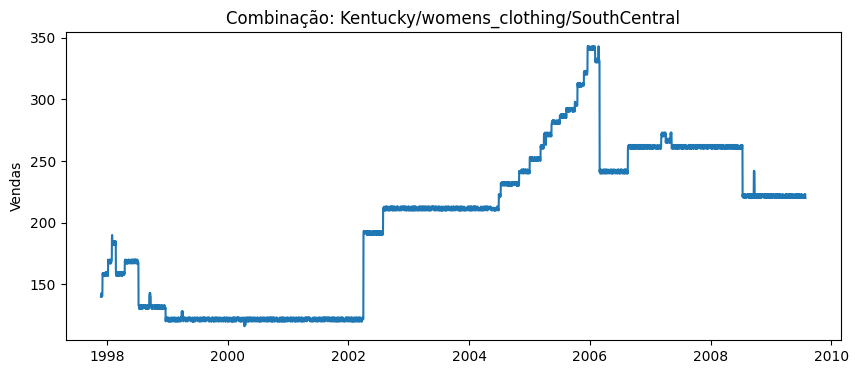

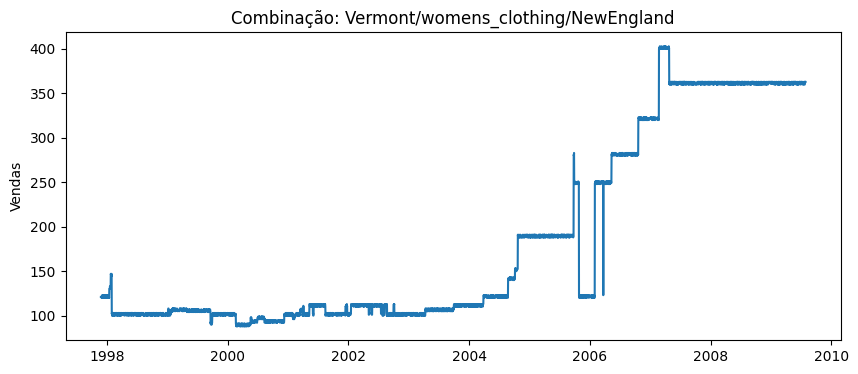

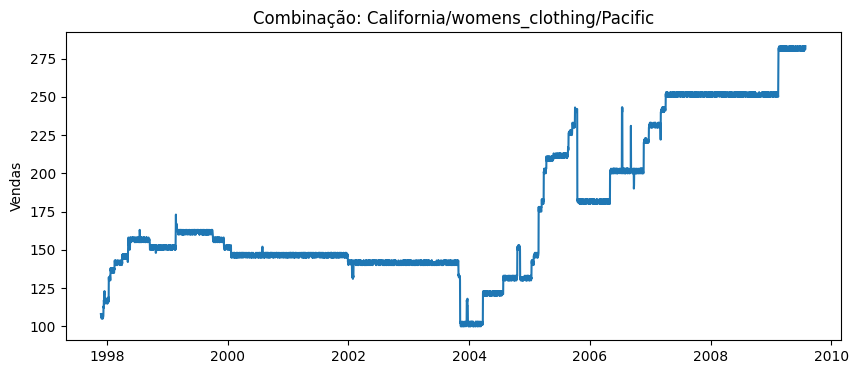

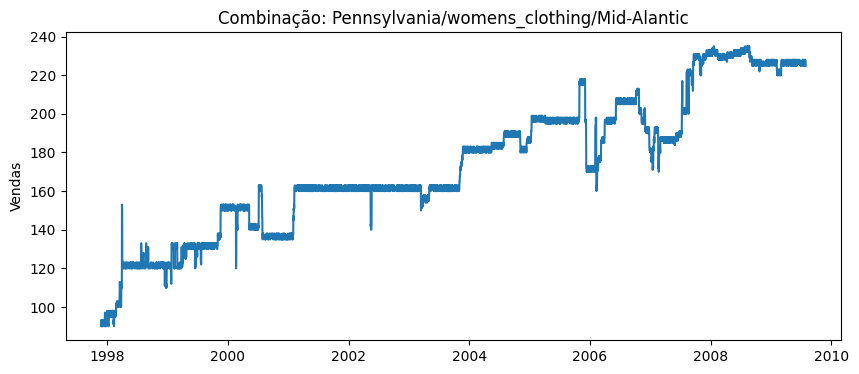

time: 1.4 s (started: 2023-12-30 12:12:12 -03:00)


In [14]:
#---- Loop para a construção dos gráficos:

for comb in df_combinacao_vendas.head().combination.tolist():

    df_temp = df\
        .query(f'combination == "{comb}"')

    plt.figure(figsize = (10, 4))
    
    _ = sns.lineplot(data = df_temp, x = 'date', y = 'quantity')
    _ = _.set_title(f'Combinação: {comb}')
    _ = plt.ylabel('Vendas')
    _ = plt.xlabel('')

### 2.5. Quantidade de combinações a serem projetadas por dia

<Axes: xlabel='date'>

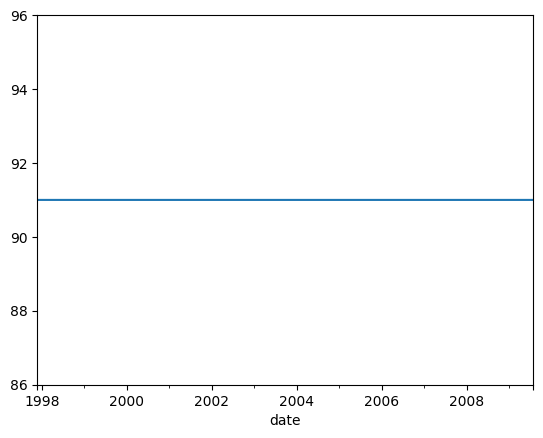

time: 269 ms (started: 2023-12-30 12:13:28 -03:00)


In [18]:
df\
    .groupby('date')['combination']\
    .nunique()\
    .plot()